Testing theory power spectra generator script

## Test theory

In [1]:
#auto load changes 
%load_ext autoreload
%autoreload 2

%load_ext line_profiler

In [2]:
import sys
import pickle
import camb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.insert(0,'/global/homes/t/tanveerk/SkyLens/') #path to skylens
sys.path.insert(0,'/global/homes/t/tanveerk/SkyLens/skylens') #path to skylens
sys.path.insert(0,'/global/homes/t/tanveerk/lselgsXplanck/src/') #path to helper functions

import healpy as hp
import skylens
import utilsCross #helper functions

from time import time

skylens init: /global/homes/t/tanveerk/SkyLens/skylens/__init__.py
skylens main: /global/homes/t/tanveerk/SkyLens/skylens/__init__.py
skylens cosmology: /global/homes/t/tanveerk/SkyLens/skylens/__init__.py
skylens main: /global/homes/t/tanveerk/SkyLens/skylens/__init__.py
skylens power spectra: /global/homes/t/tanveerk/SkyLens/skylens/__init__.py
skylens ang PS: /global/homes/t/tanveerk/SkyLens/skylens/__init__.py
skylens main: /global/homes/t/tanveerk/SkyLens/skylens/__init__.py


In [3]:
#setting up virtual dask cluster for calculations. Adjust memory and threads according to your system.
from distributed import LocalCluster
from dask.distributed import Client 
#http://distributed.readthedocs.io/en/latest/_modules/distributed/worker.html
c=LocalCluster(n_workers=1,processes=False,memory_limit='150gb',threads_per_worker=4,
               memory_spill_fraction=.99,memory_monitor_interval='2000ms')
client=Client(c)

/global/homes/t/tanveerk/.conda/envs/myenv_perlmutter/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35491 instead
  http_address["port"], self.http_server.port


In [4]:
#Import wigner files

wigner_files={} #FIXME: run Gen_wig_m0.py to generate these files and then pass their path here. These are large files, make sure they are not included in git.
# In file names l3500 refers to ell_max for which wigner function was calculated. It should be same or larger than ell_max in your measurements. 
# |w2100 is the max ell for window. This should be atleast 2 X ell_max in the measurements.
wigner_files[0]= '/pscratch/sd/t/tanveerk/wig3j_l3072_w6144_0_reorder.zarr/'

# wigner_files[2]= '/Users/Deep/dask_temp/dask_wig3j_l3500_w2100_2_reorder.zarr' #everything is spin 0, should not require this. if needed, compute using Gen_wig_m2.py

In [6]:
from astropy.cosmology import Planck18_arXiv_v2 as cosmo_planck

cosmo_fid=dict({'h':cosmo_planck.h,
                'Omb':cosmo_planck.Ob0,
                'Omd':cosmo_planck.Om0-cosmo_planck.Ob0,
                's8':0.811,
                'Om':cosmo_planck.Om0,
                'Ase9':2.2,
                'mnu':cosmo_planck.m_nu[-1].value,
                'Omk':cosmo_planck.Ok0,
                'tau':0.06,
                'ns':0.965,
                'OmR':cosmo_planck.Ogamma0+cosmo_planck.Onu0,
                'w':-1,
                'wa':0,
                'T_cmb':cosmo_planck.Tcmb0, 
                'Neff':cosmo_planck.Neff,
                'z_max':1090,
                'use_astropy':True})

In [7]:
cosmo_params = cosmo_fid

In [8]:
test = True

if test:
    NSIDE = 256
    lmax_cl = 3 * NSIDE - 1
    binsize = 10
else:
    NSIDE = 1024
    lmax_cl = 3 * NSIDE - 1
    binsize = 50

In [9]:
#setup parameters
lmin_cl=0
l0=np.arange(lmin_cl,lmax_cl)

#following defines the ell bins. Using log bins in example, feel free to change.
lmin_cl_Bins=50
lmax_cl_Bins=lmax_cl-10
Nl_bins=20
#l_bins=np.int64(np.logspace(np.log10(lmin_cl_Bins),np.log10(lmax_cl_Bins),Nl_bins))
l_bins = np.arange(lmin_cl_Bins, lmax_cl_Bins, binsize)
#lb=np.sqrt(l_bins[1:]*l_bins[:-1])
lb=0.5*(l_bins[1:]+l_bins[:-1])

l=l0

do_cov=False # if you want to get covariance. Covariance is slow and this should be false if you are calling skylens inside mcmc.
bin_cl=True #bin the theory and covaraince. 

use_window=True #if you want to include the window effect. Code will return pseudo-cl and pseudo-cl covariance
store_win=True # to store window, for some internal reasons. leave it to true.
window_lmax=3*NSIDE - 1 #smaller value for testing. This should be 2X ell_max in the measurements.

use_binned_l=False  #FIXME: to speed up computation if using pseudo-cl inside mcmc. Needs to be tested. Leave it false for now.

SSV_cov=False # we donot have good model for super sample and tri-spectrum. We can chat about implementing some approximate analytical forms.
tidal_SSV_cov=False
Tri_cov=False 

bin_xi=True
theta_bins=np.logspace(np.log10(1./60),1,20)

In [10]:
def SkyLens_cls(nside, l,  
                dndz_dict, gal_window_dict, gal_maskfile,
                cmb_SN_file, cmb_window_map_arr,
                z_cmb = 1090, zmax_cmb = 1090,
                bg1 = None, bz1 = None, mag_fact = 0, 
                zmin_gal = 0.0, zmax_gal = 1.6, nz = 75, 
                use_window = True,
                Win = None):
    """Returns Skylens Cls based on given maps.
    
    Inputs:
        nside (int) : nside for healpy
        l (array) : multipoles to evaluate 
        dndz_dict (dict) : dictionary containing dndz file location per tomographic bin
        gal_window_dict (dict) : dictionary containing galaxy window function file 
                                location per tomographic bin
        gal_maskfile (str) : Galaxy mask file location
        cmb_SN_file (str) : CMB noise curve file location 
        cmb_window_map_arr (str) : CMB window function file location
        z_cmb (float) : redshift of CMB 
        zmax_cmb (float) : maximum redshift where CMB lensing kernel should be integrated up to
        bg1 (float) : linear bias term for galaxies
        bz1 (dict) : redshift dependent galaxy bias
        mag_fact (float) : magnification bias 
        zmin_gal (float) : min redshift for galaxy sample
        zmax_gal (float) : max redshift for galaxy sample
        nz (int) : number of redshifts where P(k) will be evaluated
        use_window (bool) : whether to evaluate window function
        Win (dict) : optional dict; pass saved window calculated before
        
    Returns:
        results (dict) : Skylens dict containing Cls, pCls, coupling matrices
    """
    
    results = {}
            
    #tomographed redshift bins for the galaxies
    zl_bin = utilsCross.DESI_elg_bins(l=l, nside = nside, ntomo_bins = len(gal_window_dict), 
                                 bg1 = bg1, bz1 = bz1, mag_fact = mag_fact, 
                                 dndz_arr = dndz_dict, 
                                 gal_maskfile = gal_maskfile, gal_window_arr = gal_window_dict,
                                use_window = use_window)

    np.array([cmb_window_map_file])
    #redshift bins for cmb
    zs_bin = utilsCross.cmb_bins_here(zs = z_cmb, l=l, nside = nside, 
                                 zmax_cmb = zmax_cmb, SN_file = cmb_SN_file, 
                                 cmb_window_map_arr = cmb_window_map_arr,
                                use_window = use_window) # lensing source bin
    
    #names of maps
    corr_kk=('kappa','kappa')
    corr_gg=('galaxy','galaxy')
    corr_gk=('galaxy','kappa')
    corrs=[corr_kk, corr_gg, corr_gk]
    
    tmpz1 = np.linspace(max(zmin_gal, 1e-4), zmax_gal, nz)
    tmpz2 = np.logspace(-4, np.log10(zmax_cmb), nz) #
    z_PS = np.sort(np.unique(np.around(np.append(tmpz1, tmpz2), 
                                       decimals = 3))) #redshifts where P(k) will be evaluated
    print("z_PS: ", len(z_PS))
    if Win is not None:
        kappa0 = skylens.Skylens(kappa_zbins=zs_bin,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l0, 
                                 galaxy_zbins=zl_bin,
                                       use_window=use_window,Tri_cov=Tri_cov, Win = Win,
                                       use_binned_l=use_binned_l,wigner_files=wigner_files,
                                       SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,
                                       store_win=store_win,window_lmax=window_lmax,
                                       corrs=corrs, scheduler_info=client.scheduler_info(), log_z_PS=1,
                                       cosmo_params = cosmo_params, z_PS=z_PS, pk_params = pk_params)
        
    else:
        kappa0 = skylens.Skylens(kappa_zbins=zs_bin,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l0, galaxy_zbins=zl_bin,
                                       use_window=use_window,Tri_cov=Tri_cov, #Win = Win,
                                       use_binned_l=use_binned_l,wigner_files=wigner_files,
                                       SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,
                                       store_win=store_win,window_lmax=window_lmax,
                                       corrs=corrs, scheduler_info=client.scheduler_info(), log_z_PS=1,
                                       cosmo_params = cosmo_params, z_PS=z_PS, pk_params = pk_params)
#    results['kappa0'] = kappa0
    
#     #calculate C_ells
#     cl0G = kappa0.cl_tomo() 

#     #calculate 3x2 C_ells
#     corr_kk = ('kappa', 'kappa')
#     corr_gg = ('galaxy', 'galaxy')
#     corr_kg = ('kappa', 'galaxy')
#     bi = (0,0)

#     c_ell_dict = {} #store values
    
#     # binned theory C_ells
#     c_ell_dict['gg_binned'] = cl0G['cl_b'][corr_gg][bi].compute()
#     c_ell_dict['kg_binned'] = cl0G['cl_b'][corr_kg][bi].compute()
#     c_ell_dict['kk_binned'] = cl0G['cl_b'][corr_kk][bi].compute()
    
#     #unbinned theory C_ells
#     c_ell_dict['gg'] = cl0G['cl'][corr_gg][bi].compute()
#     c_ell_dict['kg'] = cl0G['cl'][corr_kg][bi].compute()
#     c_ell_dict['kk'] = cl0G['cl'][corr_kk][bi].compute()
    
#     #unbinned theory pseudo C_ells
#     c_ell_dict['pgg'] = cl0G['pcl'][corr_gg][bi].compute()
#     c_ell_dict['pkg'] = cl0G['pcl'][corr_kg][bi].compute()
#     c_ell_dict['pkk'] = cl0G['pcl'][corr_kk][bi].compute()
    
    return kappa0

In [11]:
client

Client Scheduler: inproc://128.55.64.34/160142/1 Dashboard: http://128.55.64.34:35491/status,Cluster Workers: 1 Cores: 4 Memory: 150.00 GB


In [12]:
"""Relevant files for tomography"""
wtype = 'nnp' #window type 
cmb_SN_file = '/pscratch/sd/t/tanveerk/cmb/lensing/MV/nlkk.dat'
gal_maskfile = '/global/homes/t/tanveerk/lselgsXplanck/finalproducts/mask_bool_dr9.npy'
cmb_window_map_file = np.array(['/global/homes/t/tanveerk/lselgsXplanck/finalproducts/mask_rotated_eq_nside_1024.npy'])
gal_window_map_file = "/global/homes/t/tanveerk/lselgsXplanck/finalproducts/Wg_map_nnp.npy"
gal_window_dict = np.array([gal_window_map_file])

#dndz file
redz_file = pd.read_csv("/global/homes/t/tanveerk/lselgsXplanck/finalproducts/fuji_pz_single_tomo.csv")
dndz = {}
dndz['zrange'] = np.array(redz_file['Redshift_mid'])
dndz['dndz'] = np.array(redz_file['pz'])
zrange = dndz['zrange']

In [13]:
pk_params={'non_linear':1,
           'kmax':30,
           'kmin':3.e-4,
           'nk':500,
           'scenario':'dmo', 
           'halofit_version':'takahashi',
           'pk_func' :'camb_pk'}

In [14]:
#define cosmology object
tmpcosmo = skylens.cosmology(cosmo_params=cosmo_params)

bg1 = None
bz1 = {}
bz1[0] = 1./tmpcosmo.DZ_int(z=zrange)

mag_bias = 2.621 # set magnification bias ##FIXME: need to change it based on Rongpu's method

### Test per function in `skylens_cl`

In [15]:
zl_bin = utilsCross.DESI_elg_bins(l=l, nside = NSIDE, ntomo_bins = 1, 
                                 bg1 = bg1, bz1 = bz1, mag_fact = mag_bias, 
                                 dndz_arr = dndz, 
                                 gal_maskfile = gal_maskfile, gal_window_arr = gal_window_dict,
                                use_window = use_window)

0.0 1.6 None 0.0030461741978670856


/global/homes/t/tanveerk/lselgsXplanck/src/utilsCross.py:113: RuntimeWarning: invalid value encountered in sqrt
  window_map_noise = np.sqrt(window_map)


In [16]:
zs_bin = utilsCross.cmb_bins_here(zs = 1090, l=l, nside = NSIDE, 
                                 zmax_cmb = 5, SN_file = cmb_SN_file, 
                                 cmb_window_map_arr = cmb_window_map_file,
                                use_window = use_window) # lensing source bin

cmb yes
processing cmb lensing window


In [17]:
zmin_gal = 0
zmax_gal = 3
nz = 75
zmax_cmb = 1090

In [18]:
tmpz1 = np.linspace(0.01, zmax_gal, nz)
tmpz2 = np.logspace(-4, np.log10(zmax_cmb), nz) #
#z_PS = np.sort(np.unique(np.around(np.append(tmpz1, tmpz2), 
#                                   decimals = 3))) #redshifts where P(k) will be evaluated
z_PS = tmpz1
print("z_PS: ", len(z_PS))

z_PS:  75


In [19]:
corr_kk=('kappa','kappa')
corr_gg=('galaxy','galaxy')
corr_gk=('galaxy','kappa')
corrs=[corr_kk, corr_gg, corr_gk]

In [20]:
kappa0 = skylens.Skylens(kappa_zbins=zs_bin, do_cov=do_cov, bin_cl=bin_cl, l_bins=l_bins, l=l0, 
                         galaxy_zbins=zl_bin,use_window=use_window, Tri_cov=Tri_cov,
                         use_binned_l=use_binned_l,wigner_files=wigner_files,
                         SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,
                         store_win=store_win,window_lmax=window_lmax,
                         corrs=corrs, scheduler_info=client.scheduler_info(), log_z_PS=1,
                         cosmo_params = cosmo_params, z_PS=z_PS, pk_params = pk_params)

Tracer utils has tracers:  ['galaxy', 'kappa']


/global/homes/t/tanveerk/SkyLens/skylens/tracer_utils.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  z_max_all=np.array([self.z_bins[tracer]['zmax'] for tracer in self.tracers])
/global/homes/t/tanveerk/SkyLens/skylens/angular_power_spectra.py:27: RuntimeWarning: divide by zero encountered in true_divide
  self.cl_f=(l+0.5)**2/(l*(l+1.)) # cl correction from Kilbinger+ 2017


power spectra camb_pk
True
Win gen: step size 177 767 768.0 1
wigner_files: {0: '/pscratch/sd/t/tanveerk/wig3j_l3072_w6144_0_reorder.zarr/'}
wigner done dict_keys([])
set window_cl: cl0,cl_b done 4.124641418457031e-05
Win_cli ('kappa', 'kappa', 0, 0) ('kappa', 'kappa') (0, 0)
Win_cli ('galaxy', 'galaxy', 0, 0) ('galaxy', 'galaxy') (0, 0)
Win_cli ('galaxy', 'kappa', 0, 0) ('galaxy', 'kappa') (0, 0)
set window_cl: cl done 0.002259492874145508 302.082 0.0
cl+cov bags done 3 0 0.2510960102081299
set_window_cl done 11.18896222114563
setting windows, coupling matrices  <Client: 'inproc://128.55.64.34/160142/1' processes=1 threads=4, memory=150.00 GB>
doing lm 0
done lm cl+cov graph 0 0.0005190372467041016 604.072 inproc://128.55.64.34/160142/3
done lm 0 0.48819494247436523
doing lm 177
done lm cl+cov graph 177 0.0008819103240966797 604.072 inproc://128.55.64.34/160142/3
done lm 177 0.47370314598083496
doing lm 354
done lm cl+cov graph 354 0.0007050037384033203 604.072 inproc://128.55.64.34/1

In [21]:
cl0G = kappa0.cl_tomo()

scatter_dict got empty dictionary
[('kappa', 'kappa'), ('galaxy', 'galaxy'), ('galaxy', 'kappa')]
cl graph done
gather_dict got empty dictionary


In [22]:
cl0G.keys()

dict_keys(['stack', 'cl_b', 'cov', 'cl', 'pseudo_cl', 'pseudo_cl_b', 'zkernel'])

In [23]:
bi = (0,0)

/global/homes/t/tanveerk/SkyLens/skylens/tracer_utils.py:374: RuntimeWarning: invalid value encountered in true_divide
  kernel['gkernel_int']/=np.sum(pz_zl*dzl)
/global/homes/t/tanveerk/SkyLens/skylens/tracer_utils.py:374: RuntimeWarning: invalid value encountered in true_divide
  kernel['gkernel_int']/=np.sum(pz_zl*dzl)
/global/homes/t/tanveerk/SkyLens/skylens/tracer_utils.py:374: RuntimeWarning: invalid value encountered in true_divide
  kernel['gkernel_int']/=np.sum(pz_zl*dzl)
/global/homes/t/tanveerk/SkyLens/skylens/tracer_utils.py:374: RuntimeWarning: invalid value encountered in true_divide
  kernel['gkernel_int']/=np.sum(pz_zl*dzl)
10:39:15 DEBUG:vmin 0.7174449145176851 vmax 1067.6777889142288
10:39:15 DEBUG:ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
10:39:15 DEBUG:vmin 0.7174449145176851 vmax 1067.6777889142288
10:39:15 DEBUG:ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
10:39:15 DEBUG:vmin 0.717444914517

bias_func: 0.0
bias_func: 0.0
bias_func: 44515.47462775605
bias_func: 44515.47462775605
bias_func: 44515.47462775605
bias_func: 0.0
bias_func: 44515.47462775605
bias_func: 0.0


10:39:15 DEBUG:ticklocs array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04])
10:39:15 DEBUG:vmin 3.665809523949454e-09 vmax 5.58715448302679e-06
10:39:15 DEBUG:ticklocs array([2.e-10, 3.e-10, 4.e-10, 5.e-10, 6.e-10, 7.e-10, 8.e-10, 9.e-10,
       2.e-09, 3.e-09, 4.e-09, 5.e-09, 6.e-09, 7.e-09, 8.e-09, 9.e-09,
       2.e-08, 3.e-08, 4.e-08, 5.e-08, 6.e-08, 7.e-08, 8.e-08, 9.e-08,
       2.e-07, 3.e-07, 4.e-07, 5.e-07, 6.e-07, 7.e-07, 8.e-07, 9.e-07,
       2.e-06, 3.e-06, 4.e-06, 5.e-06, 6.e-06, 7.e-06, 8.e-06, 9.e-06,
       2.e-05, 3.e-05, 4.e-05, 5.e-05, 6.e-05, 7.e-05, 8.e-05, 9.e-05,
       2.e-04, 3.e-04, 4.e-04, 5.e-04, 6.e-04, 7.e-04, 8.e-04, 9.e-04])
10:39:16 DEBUG:vmin 3.665809523949454e-09 vmax 5.58715448302679e-06
10:39:16 DEBUG:ticklocs array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04])
10:39:16 DEBUG:vmin 3.665809523949454e-09 vmax 5.58715448302679e-06
10:39:16 DEBUG:ticklocs array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04])
10:39:16 D

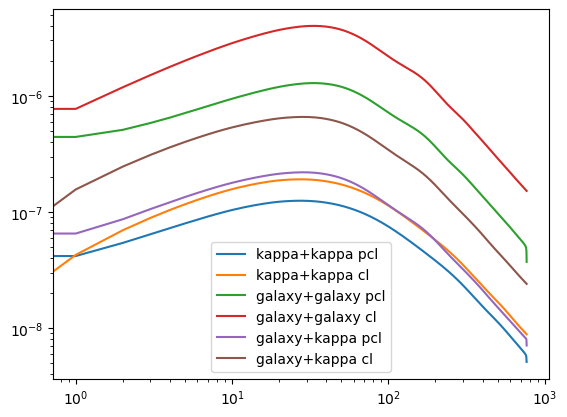

In [34]:
for corr in corrs:
    plt.loglog(client.compute(cl0G['pseudo_cl'][corr][bi]).result(), label = corr[0] + "+" + corr[1] + ' pcl')
    plt.loglog(client.compute(cl0G['cl'][corr][bi]).result(), label = corr[0] + "+" + corr[1] + ' cl')
    
plt.legend(loc = 'best')
plt.show()

In [35]:
#calculate C_ells
cl0G = kappa0.cl_tomo() 

#calculate 3x2 C_ells
corr_kk = ('kappa', 'kappa')
corr_gg = ('galaxy', 'galaxy')
corr_kg = ('kappa', 'galaxy')
bi = (0,0)

c_ell_dict = {} #store values

# binned theory C_ells
c_ell_dict['gg_binned'] = cl0G['cl_b'][corr_gg][bi].compute()
c_ell_dict['kg_binned'] = cl0G['cl_b'][corr_kg][bi].compute()
c_ell_dict['kk_binned'] = cl0G['cl_b'][corr_kk][bi].compute()

#unbinned theory C_ells
c_ell_dict['gg'] = cl0G['cl'][corr_gg][bi].compute()
c_ell_dict['kg'] = cl0G['cl'][corr_kg][bi].compute()
c_ell_dict['kk'] = cl0G['cl'][corr_kk][bi].compute()

#unbinned theory pseudo C_ells
c_ell_dict['pgg'] = cl0G['pseudo_cl'][corr_gg][bi].compute()
c_ell_dict['pkg'] = cl0G['pseudo_cl'][corr_kg][bi].compute()
c_ell_dict['pkk'] = cl0G['pseudo_cl'][corr_kk][bi].compute()

#binned theory pseudo C_ells
c_ell_dict['pgg_binned'] = cl0G['pseudo_cl_b'][corr_gg][bi].compute()
c_ell_dict['pkg_binned'] = cl0G['pseudo_cl_b'][corr_kg][bi].compute()
c_ell_dict['pkk_binned'] = cl0G['pseudo_cl_b'][corr_kk][bi].compute()

scatter_dict got empty dictionary
[('kappa', 'kappa'), ('galaxy', 'galaxy'), ('galaxy', 'kappa')]
cl graph done
gather_dict got empty dictionary
bias_func: 44515.47462775605
bias_func: 0.0
bias_func: 44515.47462775605
bias_func: 0.0
bias_func: 44515.47462775605
bias_func: 44515.47462775605
bias_func: 0.0
bias_func: 0.0
bias_func: 44515.47462775605
bias_func: 44515.47462775605
bias_func: 0.0
bias_func: 0.0
bias_func: 44515.47462775605


/global/homes/t/tanveerk/SkyLens/skylens/tracer_utils.py:374: RuntimeWarning: invalid value encountered in true_divide
  kernel['gkernel_int']/=np.sum(pz_zl*dzl)


bias_func: 44515.47462775605
bias_func: 0.0
bias_func: 0.0


11:02:38 DEBUG:vmin 0.7321144099338632 vmax 697.9783392682602
11:02:38 DEBUG:ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04])
11:02:38 DEBUG:vmin 0.7321144099338632 vmax 697.9783392682602
11:02:38 DEBUG:ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04])
11:02:38 DEBUG:vmin 0.7321144099338632 vmax 697.9783392682602
11:02:38 DEBUG:ticklocs array([2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04])
11:02:39 DEBUG:vmin 0.7321144099338632 vmax 697.9783392682602
11:02:39 DEBUG:ticklocs array([1.e-02, 1.e-01, 1.e+00,

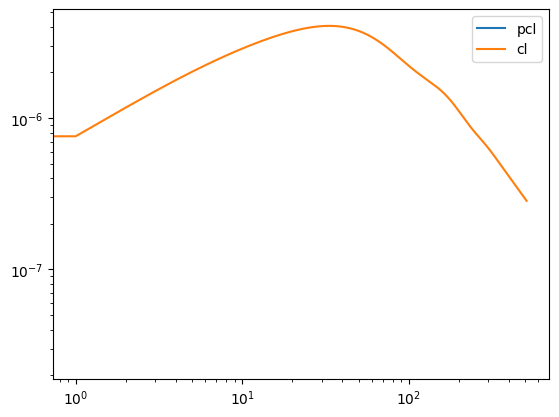

In [83]:
plt.loglog(c_ell_dict['pgg'], label = 'pcl')
plt.loglog(c_ell_dict['gg'], label = 'cl')
plt.legend(loc = 'best')
plt.show()

In [87]:
nside = NSIDE
mag_fact = mag_bias

In [106]:
dndz

{'zrange': array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05,
        1.15, 1.25, 1.35, 1.45, 1.55]),
 'dndz': array([0.0265499 , 0.12799429, 0.09807612, 0.06043074, 0.03982485,
        0.03546591, 0.12343722, 0.65403895, 1.45449862, 1.77091795,
        1.3599889 , 1.12440808, 1.0637792 , 0.86624002, 0.7198193 ,
        0.47452993])}

In [101]:
zl_bin = utilsCross.DESI_elg_bins(l=l, nside = nside, ntomo_bins = len(gal_window_dict), 
                                 bg1 = bg1, bz1 = bz1, mag_fact = mag_fact, 
                                 dndz_arr = dndz, 
                                 gal_maskfile = gal_maskfile, gal_window_arr = gal_window_dict,
                                use_window = use_window)

1.3877787807814457e-17 1.6 None 0.0030461741978670856


/global/homes/t/tanveerk/lselgsXplanck/src/utilsCross.py:105: RuntimeWarning: invalid value encountered in sqrt
  window_map_noise = np.sqrt(window_map)


In [110]:
zl_bin.keys()

dict_keys(['SN', 0, 'n_bins', 'zmax', 'zp', 'pz', 'z_bins'])

In [113]:
zl_bin[0]['nz']

array([3.43558340e-07, 1.65625886e-06, 1.26911476e-06, 7.81979803e-07,
       5.15337510e-07, 4.58932409e-07, 1.59728989e-06, 8.46332895e-06,
       1.88213565e-05, 2.29158540e-05, 1.75983914e-05, 1.45499521e-05,
       1.37654084e-05, 1.12092318e-05, 9.31453319e-06, 6.14046435e-06])

In [114]:
zl_bin[0]['pz']

array([0.0265499 , 0.12799429, 0.09807612, 0.06043074, 0.03982485,
       0.03546591, 0.12343722, 0.65403895, 1.45449862, 1.77091795,
       1.3599889 , 1.12440808, 1.0637792 , 0.86624002, 0.7198193 ,
       0.47452993])

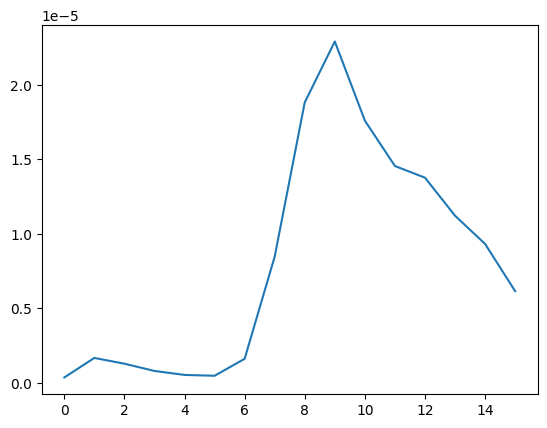

In [119]:
#plt.plot(zl_bin[0]['pz'])
plt.plot(zl_bin[0]['nz'])
plt.show()

In [124]:
zl_bin[0]['window']

array([-1.6375e+30, -1.6375e+30, -1.6375e+30, ..., -1.6375e+30,
       -1.6375e+30, -1.6375e+30])

/global/homes/t/tanveerk/.local/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/global/homes/t/tanveerk/.local/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/global/homes/t/tanveerk/.local/lib/python3.8/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you

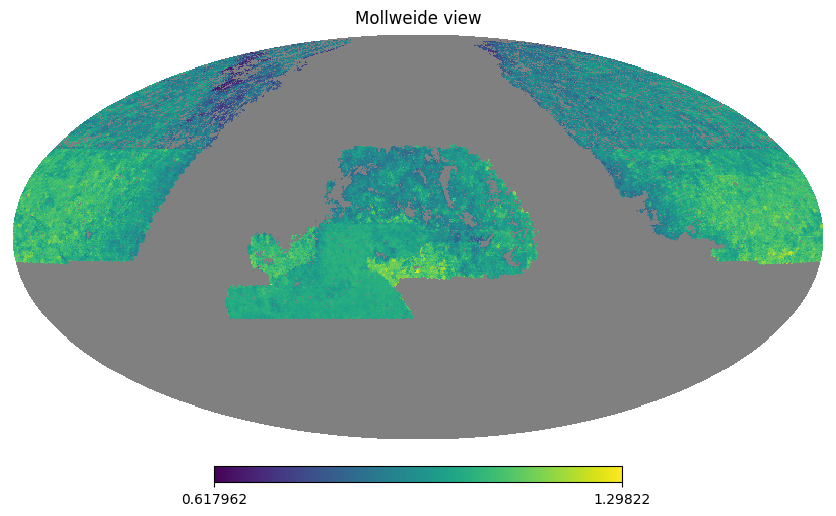

In [123]:
hp.mollview(zl_bin[0]['window'])
plt.show()

In [ ]:
def SkyLens_cls(nside, l,  
                dndz_dict, gal_window_dict, gal_maskfile,
                cmb_SN_file, cmb_window_map_arr,
                z_cmb = 1090, zmax_cmb = 1090,
                bg1 = None, bz1 = None, mag_fact = 0, 
                zmin_gal = 0.0, zmax_gal = 1.6, nz = 75, 
                use_window = True,
                Win = None):
    """Returns Skylens Cls based on given maps.
    
    Inputs:
        nside (int) : nside for healpy
        l (array) : multipoles to evaluate 
        dndz_dict (dict) : dictionary containing dndz file location per tomographic bin
        gal_window_dict (dict) : dictionary containing galaxy window function file 
                                location per tomographic bin
        gal_maskfile (str) : Galaxy mask file location
        cmb_SN_file (str) : CMB noise curve file location 
        cmb_window_map_arr (str) : CMB window function file location
        z_cmb (float) : redshift of CMB 
        zmax_cmb (float) : maximum redshift where CMB lensing kernel should be integrated up to
        bg1 (float) : linear bias term for galaxies
        bz1 (dict) : redshift dependent galaxy bias
        mag_fact (float) : magnification bias 
        zmin_gal (float) : min redshift for galaxy sample
        zmax_gal (float) : max redshift for galaxy sample
        nz (int) : number of redshifts where P(k) will be evaluated
        use_window (bool) : whether to evaluate window function
        Win (dict) : optional dict; pass saved window calculated before
        
    Returns:
        results (dict) : Skylens dict containing Cls, pCls, coupling matrices
    """
    
    results = {}
            
    #tomographed redshift bins for the galaxies
    

    np.array([cmb_window_map_file])
    #redshift bins for cmb
    zs_bin = utilsCross.cmb_bins_here(zs = z_cmb, l=l, nside = nside, 
                                 zmax_cmb = zmax_cmb, SN_file = cmb_SN_file, 
                                 cmb_window_map_arr = cmb_window_map_arr,
                                use_window = use_window) # lensing source bin
    
    #names of maps
    corr_kk=('kappa','kappa')
    corr_gg=('galaxy','galaxy')
    corr_gk=('galaxy','kappa')
    corrs=[corr_kk, corr_gg, corr_gk]
    
    tmpz1 = np.linspace(max(zmin_gal, 1e-4), zmax_gal, nz)
    tmpz2 = np.logspace(-4, np.log10(zmax_cmb), nz) #
    z_PS = np.sort(np.unique(np.around(np.append(tmpz1, tmpz2), 
                                       decimals = 3))) #redshifts where P(k) will be evaluated
    print("z_PS: ", len(z_PS))
    if Win is not None:
        kappa0 = skylens.Skylens(kappa_zbins=zs_bin,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l0, 
                                 galaxy_zbins=zl_bin,
                                       use_window=use_window,Tri_cov=Tri_cov, Win = Win,
                                       use_binned_l=use_binned_l,wigner_files=wigner_files,
                                       SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,
                                       store_win=store_win,window_lmax=window_lmax,
                                       corrs=corrs, scheduler_info=client.scheduler_info(), log_z_PS=1,
                                       cosmo_params = cosmo_params, z_PS=z_PS, pk_params = pk_params)
        
    else:
        kappa0 = skylens.Skylens(kappa_zbins=zs_bin,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l0, galaxy_zbins=zl_bin,
                                       use_window=use_window,Tri_cov=Tri_cov, #Win = Win,
                                       use_binned_l=use_binned_l,wigner_files=wigner_files,
                                       SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,
                                       store_win=store_win,window_lmax=window_lmax,
                                       corrs=corrs, scheduler_info=client.scheduler_info(), log_z_PS=1,
                                       cosmo_params = cosmo_params, z_PS=z_PS, pk_params = pk_params)
#    results['kappa0'] = kappa0
    
#     #calculate C_ells
#     cl0G = kappa0.cl_tomo() 

#     #calculate 3x2 C_ells
#     corr_kk = ('kappa', 'kappa')
#     corr_gg = ('galaxy', 'galaxy')
#     corr_kg = ('kappa', 'galaxy')
#     bi = (0,0)

#     c_ell_dict = {} #store values
    
#     # binned theory C_ells
#     c_ell_dict['gg_binned'] = cl0G['cl_b'][corr_gg][bi].compute()
#     c_ell_dict['kg_binned'] = cl0G['cl_b'][corr_kg][bi].compute()
#     c_ell_dict['kk_binned'] = cl0G['cl_b'][corr_kk][bi].compute()
    
#     #unbinned theory C_ells
#     c_ell_dict['gg'] = cl0G['cl'][corr_gg][bi].compute()
#     c_ell_dict['kg'] = cl0G['cl'][corr_kg][bi].compute()
#     c_ell_dict['kk'] = cl0G['cl'][corr_kk][bi].compute()
    
#     #unbinned theory pseudo C_ells
#     c_ell_dict['pgg'] = cl0G['pcl'][corr_gg][bi].compute()
#     c_ell_dict['pkg'] = cl0G['pcl'][corr_kg][bi].compute()
#     c_ell_dict['pkk'] = cl0G['pcl'][corr_kk][bi].compute()
    
    return kappa0